In [19]:
print('Hello world!')

Hello world!


### Experimental Setting

In [20]:
REVERSE_INPUT = True
REVERSE_OUTPUT = True
OPERATOR = '+'
NUM1_RANGE = (0,999)
NUM2_RANGE = (0,999)
TRAINING_SAMPLE_SIZE = 5000
TEST_SAMPLE_SIZE = 100
TRAINING_EPOCH = 20

### Transformer for Calculation

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [22]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed_all(12345)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [24]:
# Dataset Class
class AdditionDataset(Dataset):
    def __init__(self, num_samples):
        self.samples = [self.generate_sample() for _ in range(num_samples)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    @staticmethod
    def generate_sample(operator=OPERATOR, reverse_in=REVERSE_INPUT, reverse_out=REVERSE_OUTPUT):
        num1 = random.randint(NUM1_RANGE[0], NUM1_RANGE[1])
        num2 = random.randint(NUM2_RANGE[0], NUM2_RANGE[1])
        result = eval(f'{num1}{operator}{num2}')

        if reverse_in:
            num1 = str(num1)[::-1]
            num2 = str(num2)[::-1]
        else:
            num1 = str(num1)
            num2 = str(num2)

        if reverse_out:
            result = str(result)[::-1]
        else:
            result = str(result)

        return num1+operator+num2+'='+result

In [25]:
# Hyperparameter
MAX_LEN = 16
EMBED_SIZE = 384 #256
NUM_HEADS = 6 #8
NUM_LAYERS = 3 #6 #3
DROPOUT = 0 #0.1
LEARNING_RATE = 1e-6 #1e-3
EPOCHS = TRAINING_EPOCH

In [26]:
# Tokenization
ONEHOT_IDX = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, OPERATOR: 10, '=': 11}
TOKENS = ''.join(ONEHOT_IDX.keys())
VOCAB_SIZE = len(TOKENS)

def char_to_idx(char):
    return ONEHOT_IDX[char]

def idx_to_char(idx):
    return TOKENS[idx]

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiheadAttention(nn.Module):
    def __init__(self, d_model, num_heads, bias=True):
        super(MultiheadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        self.query_linear = nn.Linear(d_model, d_model, bias=bias)
        self.key_linear = nn.Linear(d_model, d_model, bias=bias)
        self.value_linear = nn.Linear(d_model, d_model, bias=bias)
        self.output_linear = nn.Linear(d_model, d_model, bias=bias)
        
        self.register_buffer('tril', torch.tril(torch.ones(MAX_LEN, MAX_LEN)))

    def forward(self, query, key, value):
        batch_size, seq_len, emb_dim = query.shape
        
        # Linear transformations
        query = self.query_linear(query)
        key = self.key_linear(key)
        value = self.value_linear(value)
        
        # Reshape query, key, and value
        query = query.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention scores
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        
        # Apply mask
        scores = scores.masked_fill(self.tril[:seq_len, :seq_len] == 0, float('-inf'))
        
        # Apply softmax activation
        attention_weights = F.softmax(scores, dim=-1)
        
        # Apply attention weights to value
        attention_output = torch.matmul(attention_weights, value)
        
        # Reshape attention output
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        # Linear transformation for output
        output = self.output_linear(attention_output)
        
        return output

In [28]:
import torch.nn as nn

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, bias=True, activation='relu', batch_first=False):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, bias=bias)
        self.linear1 = nn.Linear(d_model, d_model)
        self.linear2 = nn.Linear(d_model, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError(f"Unsupported activation function {activation}.")
        
        self.batch_first = batch_first

    def forward(self, src):
        src2 = self.self_attn(src, src, src)
        src = src + self.dropout(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src


In [29]:
# Model definition
class TransformerDecoderModel(nn.Module):
    def __init__(self, vocab_size, embed_size, max_len, num_heads, num_layers, dropout=0.1):
        super(TransformerDecoderModel, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_size)
        self.pos_enc = nn.Embedding(max_len, embed_size)

        self.transformer_decoder = nn.ModuleList([
            TransformerDecoderLayer(
                d_model=embed_size, 
                nhead=num_heads, 
                bias=False,
                activation='gelu',
                batch_first=True,
            ) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(embed_size, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.pos = torch.arange(0, max_len, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

    def forward(self, src):
        batch_size, seq_len = src.shape
        tok_emb = self.token_emb(src)  # (batch=1, seq_len, emb_dim)
        pos_emb = self.pos_enc(self.pos)[:,:seq_len,:]
        x = self.dropout(tok_emb + pos_emb)
        
        for layer in self.transformer_decoder:
            x = layer(x)
        
        output = self.fc_out(x)
        return output


In [30]:
# Visualization
def vis_pca(data, labels, title='', show=False):
    
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    pca = PCA(n_components=8)
    transformed_list = pca.fit_transform(data.cpu().detach().numpy())  # (label cnt, pc cnt)

    plt.figure(figsize=(14, 14))

    pc_axes = [[0,1],[2,3],[4,5],[6,7]]
    for plot_id, (pcx, pcy) in enumerate(pc_axes):
        for point_id, transformed in enumerate(transformed_list):
            plt.subplot(2, 2, plot_id+1)  # plt.subplot(row, col, i)
            plt.xlabel(f'PC{pcx+1} ({pca.explained_variance_ratio_[pcx]*100:.1f}%)')
            plt.ylabel(f'PC{pcy+1} ({pca.explained_variance_ratio_[pcy]*100:.1f}%)')
            plt.scatter(transformed[pcx], transformed[pcy], alpha=0.25)
            plt.text(transformed[pcx], transformed[pcy], f"'{labels[point_id]}'")
            
    plt.suptitle(title)

    if show:
        plt.show()
    else:
        if not os.path.exists('emb_vis'): os.makedirs('emb_vis')
        plt.savefig(f'emb_vis/pca_{time.strftime("%Y%m%d-%H%M%S")}.png', bbox_inches='tight')
        plt.close()

# vis_pca(model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device)), TOKENS, title='Test', show=True)

In [31]:
model = TransformerDecoderModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    max_len=MAX_LEN, 
    num_heads=NUM_HEADS, 
    num_layers=NUM_LAYERS, 
    dropout=DROPOUT,
    )
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [32]:
train_dataset = AdditionDataset(num_samples=TRAINING_SAMPLE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=1)

In [33]:
model = model.to(device)

In [34]:
PCA_TITLE_PREFIX = "TOP-8 Embedding PCA"

In [35]:
data = model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:0, Loss:N/A)')

In [36]:
# Train
model.train()
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in tqdm(train_loader):
        for data in batch:
            input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
            target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)

            optimizer.zero_grad()
            output = model(input_tensor)  # (batch=1, seq_len) -> (batch=1, seq_len, VOCAB_SIZE)

            output_onehot = np.argmax(output.cpu().detach(), axis=2)  # (batch=1, seq_len)
            
            pred = output.view(-1, VOCAB_SIZE)  # (seq_len, VOCAB_SIZE)
            true = target_tensor.view(-1)  # (seq_len)
            # loss = F.cross_entropy(pred, true)  # Compare all (inefficient)
            
            eqi = data[:-1].index('=')
            lhs = torch.zeros_like(pred[:eqi])
            for i in range(eqi):
                lhs[i][true[i]] = 1
            rhs_pred = torch.cat((lhs, pred[eqi:]), dim=0)  # (seq_len, VOCAB_SIZE)
            loss = F.cross_entropy(rhs_pred, true)  # Compare RHS
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()/len(batch)
    losses.append(epoch_loss/len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]}")
    
    data = model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
    vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:{epoch+1}, Loss:{losses[-1]:.2f})')

plt.title('Loss'); plt.plot(losses)

  0%|          | 0/5000 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
test_dataset = AdditionDataset(num_samples=TEST_SAMPLE_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

def evaluate_model(model, data):
    model.eval()  # 모델을 평가 모드로 설정
    
    pred_total = pred_correct = 0
    with torch.no_grad():
        for batch in test_loader:
            for data in batch:
                input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
                target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)
    
                output = model(input_tensor)

                output_onehot = np.argmax(output.cpu().detach(), axis=2)
                eqi = data[:-1].index('=')
                pred_total += len(target_tensor[0][eqi:])
                pred_correct += sum(1 for i, j in zip(target_tensor[0][eqi:], output_onehot[0][eqi:]) if i == j)
                print('sentence: ', data)
                print('target_char: ', [idx_to_char(i) for i in target_tensor[0][eqi:]])
                print('output_char: ', [idx_to_char(i) for i in output_onehot[0][eqi:]])

    return {'accuracy': pred_correct/pred_total}

accuracy = evaluate_model(model, test_dataset)['accuracy']

sentence:  677+578=1561
target_char:  ['1', '5', '6', '1']
output_char:  ['1', '5', '6', '1']
sentence:  593+519=0131
target_char:  ['0', '1', '3', '1']
output_char:  ['0', '1', '3', '1']
sentence:  247+782=9201
target_char:  ['9', '2', '0', '1']
output_char:  ['9', '2', '0', '1']
sentence:  171+553=625
target_char:  ['6', '2', '5']
output_char:  ['6', '2', '5']
sentence:  237+289=4171
target_char:  ['4', '1', '7', '1']
output_char:  ['4', '1', '7', '1']
sentence:  089+032=0121
target_char:  ['0', '1', '2', '1']
output_char:  ['0', '1', '2', '1']
sentence:  172+818=9801
target_char:  ['9', '8', '0', '1']
output_char:  ['9', '8', '0', '1']
sentence:  841+811=662
target_char:  ['6', '6', '2']
output_char:  ['6', '6', '3']
sentence:  735+269=9941
target_char:  ['9', '9', '4', '1']
output_char:  ['9', '9', '4', '1']
sentence:  984+676=5611
target_char:  ['5', '6', '1', '1']
output_char:  ['5', '6', '1', '1']
sentence:  626+672=209
target_char:  ['2', '0', '9']
output_char:  ['2', '0', '9']

In [ ]:
print("Accuracy: ", accuracy)

Accuracy:  0.9915014164305949


In [ ]:
# Write experimental results
if not os.path.exists('emb_vis'): os.makedirs('emb_vis')
filename=f'exp_res/{accuracy*100:.0f}-InRev{REVERSE_INPUT}-OutRev{REVERSE_OUTPUT}-{NUM1_RANGE}-{NUM2_RANGE}-Train{TRAINING_SAMPLE_SIZE}-Test{TEST_SAMPLE_SIZE}-Epoch{TRAINING_EPOCH}-{time.strftime("%Y%m%d-%H%M%S")}.txt'
with open(filename, 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(f'Loss: {losses}\n')

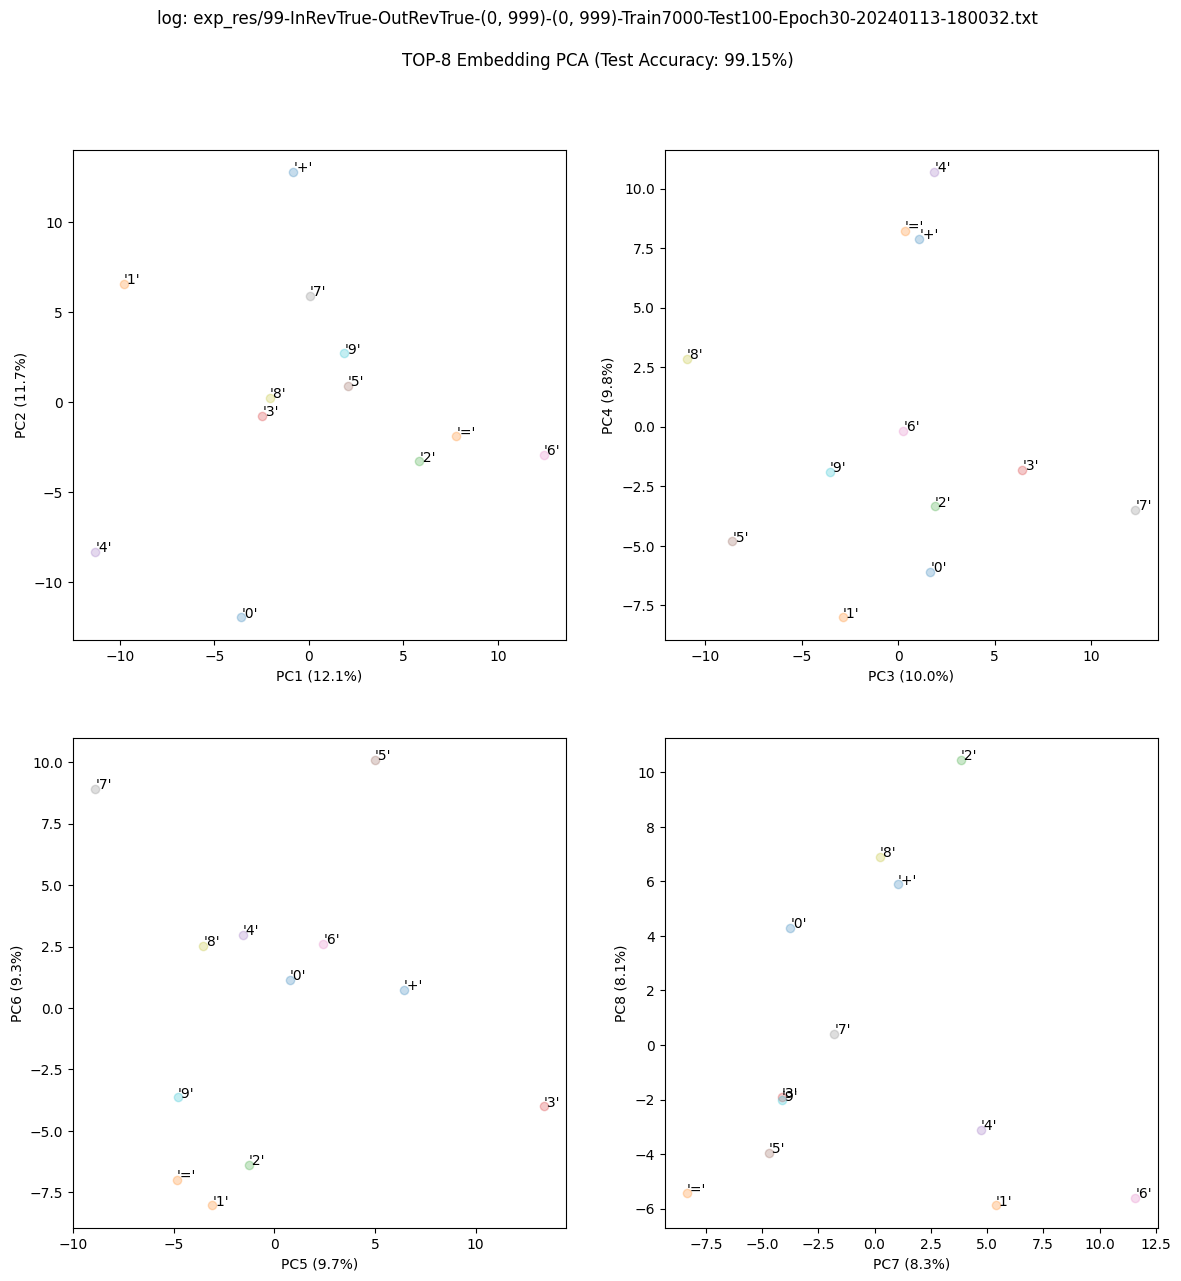

In [ ]:
vis_pca(data, TOKENS, title=f'log: {filename}\n\n{PCA_TITLE_PREFIX} (Test Accuracy: {accuracy*100:.2f}%)', show=True)